# The problem:
We are looking for a model, which can predict the call volume for the Seattle Fire Department for each day of the year and
each hour of the day.
# Libararies and Packages:

In [1]:
#Read and process data
import pandas as pd
#Plotting
import matplotlib.pyplot as plt
#For analysis
import numpy as np
from scipy import fftpack
from scipy import stats
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm
import itertools

# Data Visualization and Investigation
The data for 911 calls is publically available at https://data.seattle.gov/Public-Safety/Seattle-Real-Time-Fire-911-Calls/kzjm-xkqj. It is a log of the date and time of each call since the year 2003.
## Initial Inspection: 

In [2]:
#Import dataframe, and specify that 'Datetime' column is the timestamp and index
data_url ='https://data.seattle.gov/api/views/kzjm-xkqj/rows.csv?accessType=DOWNLOAD'
df_calls_original = pd.read_csv(data_url, parse_dates=['Datetime'], index_col='Datetime')

In [3]:
#Sort and display some of the dataframe 
df_calls_original.sort_values(by=['Datetime'], inplace=True)
df_calls_original.head()

,Address,Type,Latitude,Longitude,Report Location,Incident Number
Datetime,,,,,,
2003-11-07 09:30:48,507 W Mercer St,Medic Response,47.624608,-122.363505,POINT (-122.363505 47.624608),F030080834
2003-11-07 09:31:47,4104 Meridian Av N,Medic Response,47.656799,-122.333806,POINT (-122.333806 47.656799),F030080835
2003-11-07 09:43:15,11650 Beacon Av S,Auto Fire Alarm,47.498464,-122.263967,POINT (-122.263967 47.498464),F030080841
2003-11-07 09:50:05,1518 Nw 60th St,1RED 1 Unit,47.672360,-122.376440,POINT (-122.37644 47.67236),F030080842
2003-11-07 09:56:10,8499 Tillicum Rd Sw,Aid Response Yellow,47.527277,-122.388451,POINT (-122.388451 47.527277),F030080843


First, I examine the mean number of calls at different time intervals. This is done by grouping calls in each time interval (by day, by the hour so on), then calculating the mean value in each of these groups.

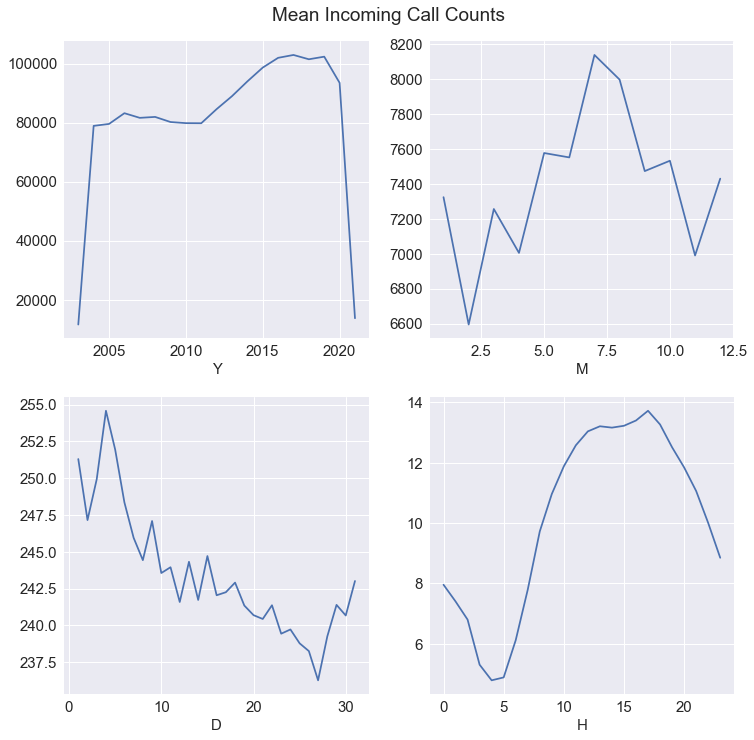

In [4]:
plt.style.use('seaborn')
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(12,12))
ax = axes.ravel()
plt.suptitle(f'Mean Incoming Call Counts',y=0.92, fontsize = 19)

def resample_plot(df_calls_original):
    interval = ['Y', 'M', 'D', 'H']
    for i in range(4):
        resampled_original = df_calls_original['Incident Number'].resample(interval[i]).count() 
        types = [resampled_original.index.year, resampled_original.index.month, 
                 resampled_original.index.day, resampled_original.index.hour]
        ax[i].plot(resampled_original.groupby(by=types[i]).mean()) 
        ax[i].tick_params(labelsize=15)
        ax[i].set_xlabel(interval[i], fontsize = 15)
        
resample_plot(df_calls_original)

## Features:
### Yearly mean:
The upper panel on the left-hand side shows the mean call count in each year. There is a sharp drop around 2003 and 2021 because data of these years are incomplete. Both points can be ignored when analysing the yearly trend. The mean value seems to have little variations before 2010. Afterwhich, an overall increase in the number of calls can also be observed until 2015, where we see little variations again. This could be since beginning in 2010, and for the next five years, Seattle gained an average of 14,511 residents per year. A noticeable decrease is seen in 2020. This could be due to the pandemic outbreak and the fact that people overall spent less time outside.
### Monthly mean:
Calls are highest during the summer months than they are during winter, with a sharp drop in February and an increase in July, which shows a correlation to temperature degree. This drop-in winter could also be attributed to people spending more times at home.
### Daily mean:
It seems that the number of calls is higher towards the beginning of the month and decreases as the end of the month approaches. However, the actual difference between the two peaks is not very high. It could be attributed to noise.
### Hourly mean:
Finally, we can see that during 'working hours' 8 am and 8 pm the number of calls would be the highest, with a sharp drop shortly before 5 am. 

We inspect also the daily count of calls throughout every year between the years 2015 and 2020. This is after the increase in trend due to population has happened. The count is smoothed with a window function of size 30 days. 

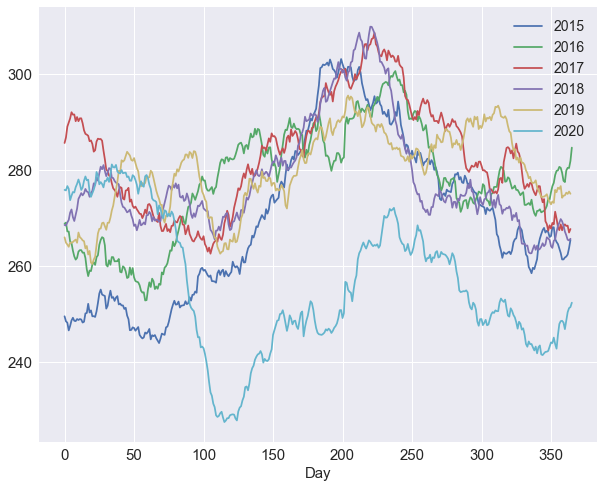

In [18]:
plt.figure(figsize=(10,8))
value_count = df_calls_original['Incident Number'].resample('D').count().rolling(30).mean()
for i in range (2015, 2021):
    yearly_trend = value_count[value_count.index.year==i].values
    plt.plot(yearly_trend, label = i)
plt.tick_params(labelsize=15)
plt.xlabel('Day', fontsize = 15)
plt.legend(fontsize = 14)
plt.show()

The daily count in every year plot shows that the year 2020 started similar to other years, and around March, which is around the beginning of the Pandemic, the call count drops sharply and stays low until the year ends. This plot demonstrates that the year 2020 is an outlier, and shouldn't be used to predict future trends. That is, supposing things return to normal.

# Analysis
From previous plots, we can deduce that there is:
1. A yearly trend
2. Periodic change between winter and summer
3. A low amplitude change over the course of a month
3. Periodic change depending on the time of day

We should first discard the years 2003, 2020 and 2021:

In [6]:
df = df_calls_original.loc[(df_calls_original.index >= '2004') & (df_calls_original.index < '2020')]

## Fourier Transform:

My first approach to this problem is to decompose it into its components using a Fourier transform. The approach is straightforward: 
1. Run FFT
2. Filter out the noise
3. Obtain peak frequency and amplitude
4. Reverse FFT

To keep it somewhat simple, for each component, I will filter out the second highest-amplitude frequency and discard all higher frequencies as noise. The highest amplitude frequency should be around 0 Hz representing the offset, which I account for by adding the mean value of the count as a constant offset.

In [7]:
def  fft_peaks(value_original):
    value_fft = fftpack.fft(value_original)
    
    #Amplitude, we sort to make it easier to get the highest value:
    amp = np.abs(value_fft)
    amp_sorted = amp[np.argsort(amp)]
    #Frequency:
    freq = fftpack.fftfreq(value_fft.size)
    freq_sorted = freq[np.argsort(amp)]
    
    #This chooses the two frequincies with the highest amplitude, one is the constant offset and the second is time dependate
    highest_freq = freq_sorted[-2]
    highest_amp = amp_sorted[-2]
    
    #Filter noise:
    filted_freq_fft = np.copy(value_fft)
    filted_freq_fft[np.abs(freq_sorted) > np.abs(highest_freq)] = 0
    
    #Inverse Fourier transform to get back non-noisy results
    filtered_value = np.real_if_close(fftpack.ifft(filted_freq_fft))
    
    return(highest_freq, highest_amp, filtered_value.real + value_original.mean())

C:\Users\hfoua\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:2064: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
C:\Users\hfoua\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:248: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]


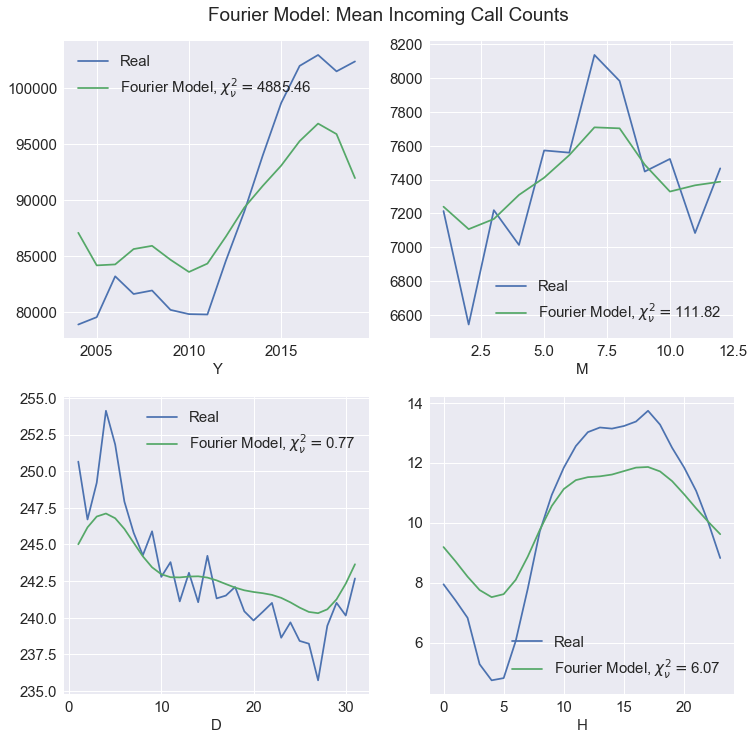

In [8]:
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(12,12))
ax = axes.ravel()
plt.suptitle(f'Fourier Model: Mean Incoming Call Counts',y=0.92, fontsize = 19)

def resample_plot_mod(df):
    interval = ['Y', 'M', 'D', 'H']
    for i in range(4):
        resampled = df['Incident Number'].resample(interval[i]).count() 
        
        types = [resampled.index.year, resampled.index.month, 
                 resampled.index.day, resampled.index.hour]
        
        value_original = resampled.groupby(by=types[i]).mean()
        
        peak_freq, peak_amp, filtered_value = fft_peaks(value_original.values)
        
        chi = stats.chisquare(value_original, filtered_value , ddof = len(value_original)-1)[0]
        
        ax[i].plot(value_original, label = 'Real')
        ax[i].plot(value_original.index, filtered_value , label = r'Fourier Model, $\chi^2_{\nu} = $'+\
           str(np.round(chi,2)))
        ax[i].tick_params(labelsize=15)
        ax[i].set_xlabel(interval[i], fontsize = 15)
        ax[i].legend(fontsize = 15)

        
resample_plot_mod(df)

Visual observation shows a lack of capturing peak count values, but it works well to predict the mean. To better quantify this model, we use the reduced $\chi^2$. The High values of $\chi^2_{\nu}$ shows that is model is not good at predicting yearly, monthly or hourly rates. It works well for Daily change. This result is expected as this model is overly simplified. 

## SARIMA:
As a more robust model, I use SARIMA. It is a combination of simpler models. SARIMA stands for the seasonal autoregressive integrated moving average model.

- Autoregression AR(p): Is regression of the time series onto itself. Here, we assume that the current value depends on its previous values with some lag. It takes a parameter p which represents the maximum lag.
- Moving average MA(q): This takes a parameter q which represents the biggest lag after which other lags are not significant on the autocorrelation plot.
- Order of integration I(d). The parameter d represents the number of differences required to make the series stationary, i.e. it would have a constant mean and variance.
- Finally The seasonality S(P, D, Q, s): where s is the season’s length. P and Q are the same as p and q, but for the seasonal component. Finally, D is the order of seasonal integration representing the number of differences required to remove seasonality from the series.


This is a Bayesian approach. It iterates through different values of the parameters then uses minimising the Akaike’s Information Criterion (AIC) which is a function of the likelihood to obtain the best fit model.

For this model, I will use a sample of the number of calls in every hour, each day as my data.

In [9]:
Hourly_count = df['Incident Number'].resample('H').count()[::100]

In [10]:
#Set the range of parameters from which we will sample:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
for x in pdq:
    seasonal_pdq = [(x[0], x[1], x[2], 12) ]

In [11]:
#set initial values
my_aic=1e7 
my_model = ARIMA(Hourly_count.values, order=(0,0,0))

for param in pdq:
    for param_seasonal in seasonal_pdq:

        model = sm.tsa.statespace.SARIMAX(Hourly_count,order=param,seasonal_order=param_seasonal,\
                                            enforce_stationarity=False, enforce_invertibility=False)
        results = model.fit()
        if results.aic < my_aic:
                my_aic = results.aic
                my_model = model


In [12]:
#Summary of SARIMA model:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                    Incident Number   No. Observations:                 1403
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -3699.684
Date:                            Wed, 24 Feb 2021   AIC                           7409.368
Time:                                    21:46:14   BIC                           7435.503
Sample:                                01-01-2004   HQIC                          7419.147
                                     - 12-29-2019                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0200      0.027      0.734      0.463      -0.033       0.073
ma.L1         -0.9898      0.005   -203.683      0.000      -0.999      -0.980
ar.S.L12     6.13e-06      0.024      0.000      1.000      -0.047       0.047
ma.S.L12      -1.0226      0.011    -94.020      0.000      -1.044      -1.001
sigma2        11.8203      0.430     27.468      0.000      10.977      12.664
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                78.32
Prob(Q):                              0.93   Prob(JB):                         0.00
Heteroskedasticity (H):               1.11   Skew:                             0.49
Prob(H) (two-sided):                  0.28   Kurtosis:                         3.65
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [13]:
#Prediction
pred = results.get_prediction(start = '2018-01-03 16:00:00 ', end = '2021-4-29 16:00:00', dynamic=False)
#95% confidence interval
pred_ci = pred.conf_int() 

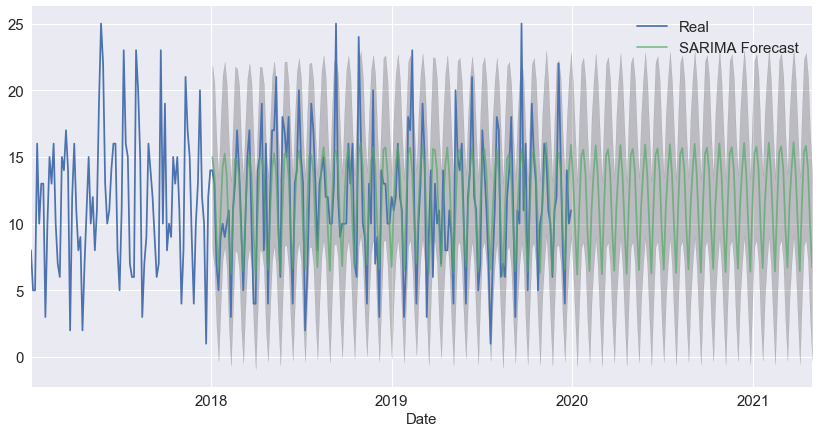

In [19]:
ax = Hourly_count['2017':].plot(label='Real')
pred.predicted_mean.plot(ax=ax, label='SARIMA Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index, pred_ci.iloc[:, 0], pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date', fontsize = 15)
ax.tick_params(labelsize=15)
ax.legend(fontsize = 15)
plt.show()

In [14]:
#Comparitive plots
def comp_plots(Hourly_count, pred, pred_ci, upperlim):
    ax = Hourly_count['2017':].plot(label='Real')
    pred.predicted_mean.plot(ax=ax, label='SARIMA Forecast', alpha=.7, figsize=(14, 7))
    ax.fill_between(pred_ci.index, pred_ci.iloc[:, 0], pred_ci.iloc[:, 1], color='k', alpha=.2)
    ax.set_xlabel('Date', fontsize = 15)
    ax.set_xlim('2018-01-20 20:00:00', upperlim)
    ax.tick_params(labelsize=15)
    ax.legend(fontsize = 15)
    plt.show()

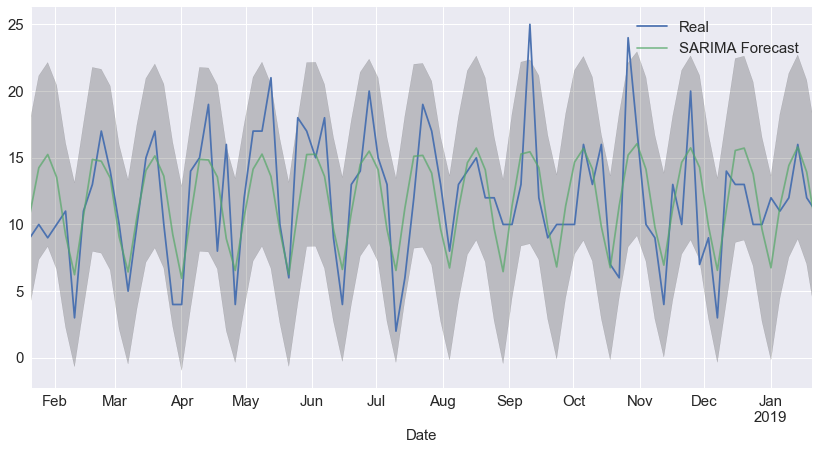

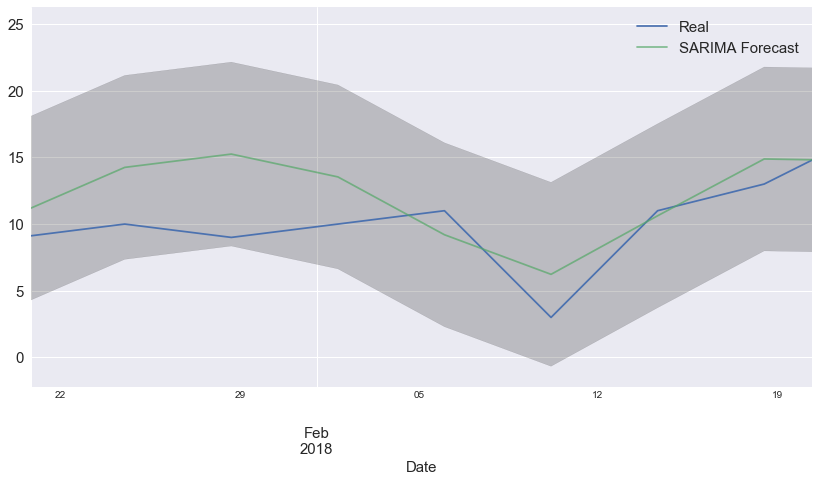

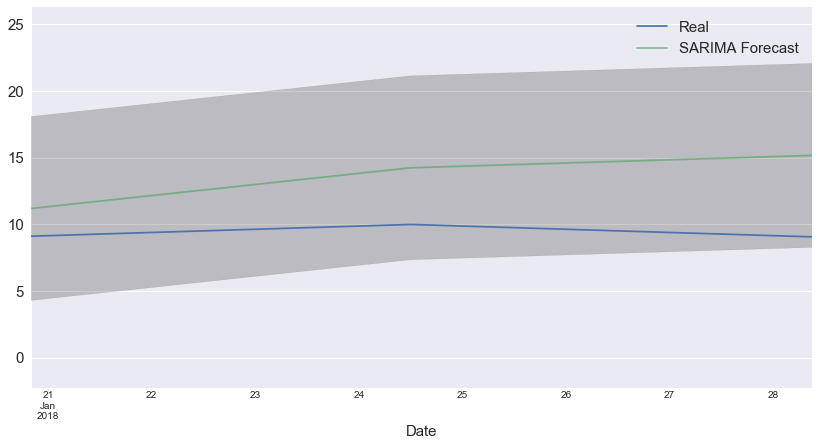

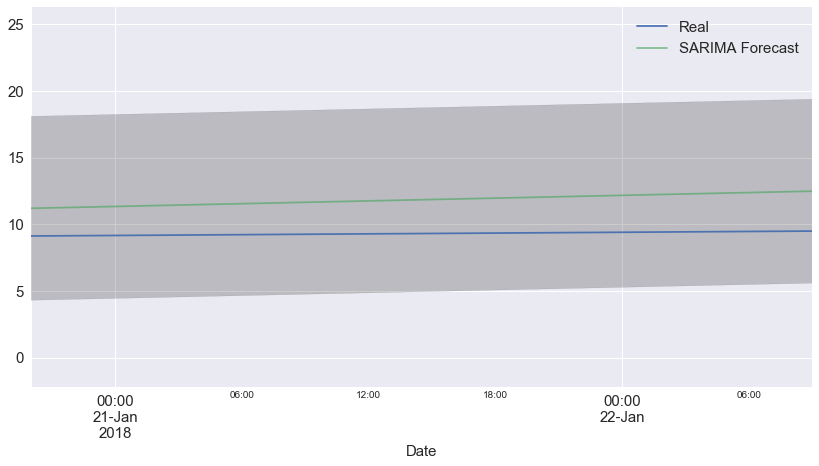

In [15]:
intervals = ['2019-01-20 09:00:00', '2018-02-20 09:00:00', '2018-01-28 09:00:00', '2018-01-22 09:00:00']
for i in range(4):
    comp_plots(Hourly_count, pred, pred_ci, intervals[i])

It can be noticed that while the model seems to recreate the features throughout on large scales, on small scales it seems to be overpredicting the number count.

### Diagnostic plots:

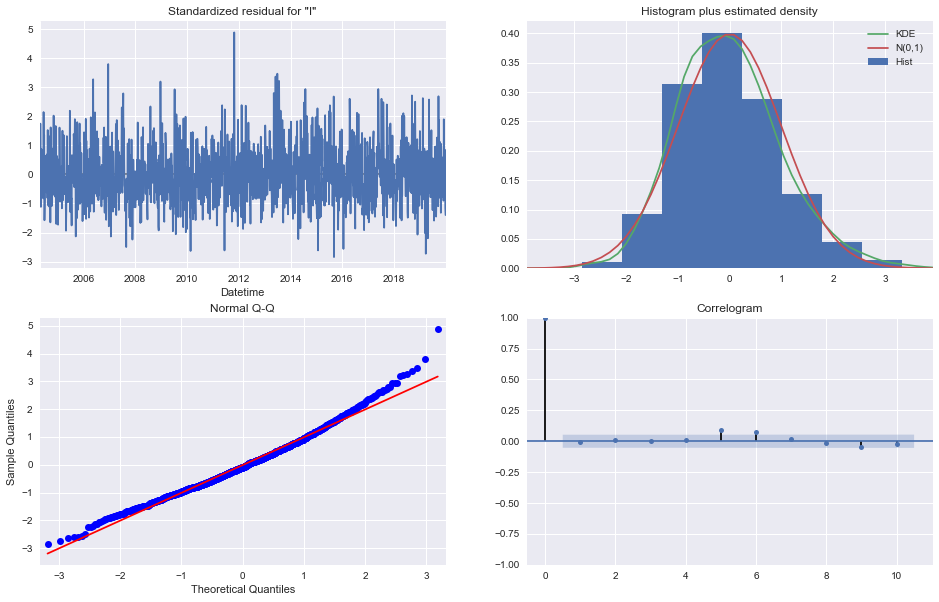

In [16]:
results.plot_diagnostics(figsize=(16, 10))
plt.show()

- The upper left panel is the plot of the standardized residuals. It seems to be oscillating around the zero line. This shows that the predicted values are not very far from the theoretical ones.
- The upper right is panel is a histogram and estimated density of standardized residuals, along with a Normal(0,1) density plotted for reference. It can be seen that the KDE (green curve) is a bit skewed to the left side of the normal distribution. This is an indication of overprediction.
- The lower left panel is a normal Q-Q plot, with a normal reference line. If the predicted result = data, the blue points would fit over the red line. However, the overprediction can again, be seen on the upper right side of the plot.
- Finally, the last panel is the correlogram. It is a plot of sample autocorrelations and the time lags. The first peak is just the correlation of a time series with itself. The rest of the peaks could be attributed to noise